In [295]:
# Read libraries

# Data wrangling
import pandas as pd
import numpy as np
import re
import pycountry
from shapely import wkt
import fiona
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Visualization 
import missingno as msno
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import geopandas as gpd

# Machine learning 
from sklearn.cluster import KMeans
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

1. Read in the HFI data

In [296]:
df_2022 = pd.read_csv('/Users/albertcortbanke/Downloads/thesis_missing_data_2023/hfi/hfi_cc_2022.csv')

2. Read in the GeoJSON data

In [297]:
countries_gpd = gpd.read_file('/Users/albertcortbanke/Downloads/thesis_missing_data_2023/country_geometry_json/world-administrative-boundaries.shp')

3. Read in the Global South/North data

In [298]:
global_sn = pd.read_csv('/Users/albertcortbanke/Downloads/thesis_missing_data_2023/global_south_north/global_s_n.csv')

In [299]:
# Extract the columns of interest (CCA3 for merge)
global_sn = global_sn[['cca3', 'globalNorth']]

# Remap the True/False to 1/0
global_sn['globalNorth'] = global_sn['globalNorth'].map({True: 1, False: 0})

# Rename the cca3 column to country_code for merge purposes later on
global_sn = global_sn.rename(columns={'cca3': 'country_code'})

# Check it worked
global_sn

,country_code,globalNorth
0,IND,0
1,CHN,0
2,IDN,0
3,PAK,0
4,NGA,0
...,...,...
190,MCO,1
191,SMR,1
192,PLW,1
193,TUV,1


What can the Human Freedom Score measure, and more importantly, what is it unable to measure?
What attributes are the most important to explore missingness within? (I.e what attributes correlate highly, and would be pointless to measure within)

Spatial, and temporal missingness. How do we address this with spatial models and temporal accountance?


## Merging of geometries, global south/north and HFI data frame

3. Creating a mapping function to convert country names to their corresponding ISO 3166-1 alpha-3 country codes:

In [300]:
def get_country_code(country_name):
    # Handle exceptions directly
    exception_mapping = {
        'Democratic Republic of the Congo': 'COD',
        'The Bahamas': 'BHS',
        'Ivory Coast': 'CIV',
        'Iran': 'IRN',
        'Laos': 'LAO',
        'Russia': 'RUS'
    }
    
    if country_name in exception_mapping:
        return exception_mapping[country_name]
    
    try:
        return pycountry.countries.lookup(country_name).alpha_3
    except Exception:
        return None


In [301]:
# Extra mapping for codes that are fuzzy matching

country_name_mapping = {
    'Bahamas, The': 'The Bahamas',
    'Congo, Dem. Rep.': 'Democratic Republic of the Congo',
    'Congo, Rep.': 'Republic of the Congo',
    "Cote d'Ivoire": 'Ivory Coast',
    'Egypt, Arab Rep.': 'Egypt',
    'Gambia, The': 'Gambia',
    'Hong Kong SAR, China': 'Hong Kong',
    'Iran, Islamic Rep.': 'Iran',
    'Korea, Rep.': 'South Korea',
    'Lao PDR': 'Laos',
    'Venezuela, RB': 'Venezuela',
    'Yemen, Rep.': 'Yemen'
}

In [302]:
# Use the fuzzy matching to begin with
df_2022['countries'] = df_2022['countries'].replace(country_name_mapping)

# Create a new column with the correct ISO-country codes using the get_country_code function
df_2022['country_code'] = df_2022['countries'].apply(get_country_code)

In [303]:
# Renaming the iso3 column to country_code in the countries_gpd df for easier matching
countries_gpd = countries_gpd.rename(columns={"iso3": "country_code"})

In [304]:
# Select only the 'country_code' and 'geometry' columns from the GeoPandas DataFrame
countries_gpd_filtered = countries_gpd[['country_code', 'geometry']]

# Merge the DataFrames on the 'country_code' column
sample_merged = df_2022.merge(countries_gpd_filtered, on='country_code', how='left')

# Merge the Dataframe, again, on the 'country_code' column to get the global_north attribute
merged_gdf = sample_merged.merge(global_sn, on='country_code', how='left')

# Convert the merged DataFrame to a GeoDataFrame, using the 'geometry' column as the geometry
merged_gdf = gpd.GeoDataFrame(merged_gdf, geometry='geometry')

In [305]:
# Check if there are non-matched values for the geometries/polygons
merged_gdf.geometry.isnull().value_counts()

False    3486
Name: geometry, dtype: int64

In [306]:
# Check if there are non-matched values for the globalNorth
merged_gdf.globalNorth.isnull().value_counts()

False    3444
True       42
Name: globalNorth, dtype: int64

In [307]:
# After further inspection of the above information and DF, Taiwan and Hong Kong needs to mapped manually 
merged_gdf.loc[merged_gdf['country_code'] == 'HKG', 'globalNorth'] = 1.0
merged_gdf.loc[merged_gdf['country_code'] == 'TWN', 'globalNorth'] = 1.0

In [308]:
# Save the DataFrame as a Parquet file
gdf_nonproc = gpd.GeoDataFrame(merged_gdf, geometry='geometry')

# Save the GeoDataFrame as a GeoParquet file
gdf_nonproc.to_parquet('gdf_nonproc.parquet', compression='snappy', index=False)

## Feature selection (mulitcollinarity & VIF)

<AxesSubplot:>

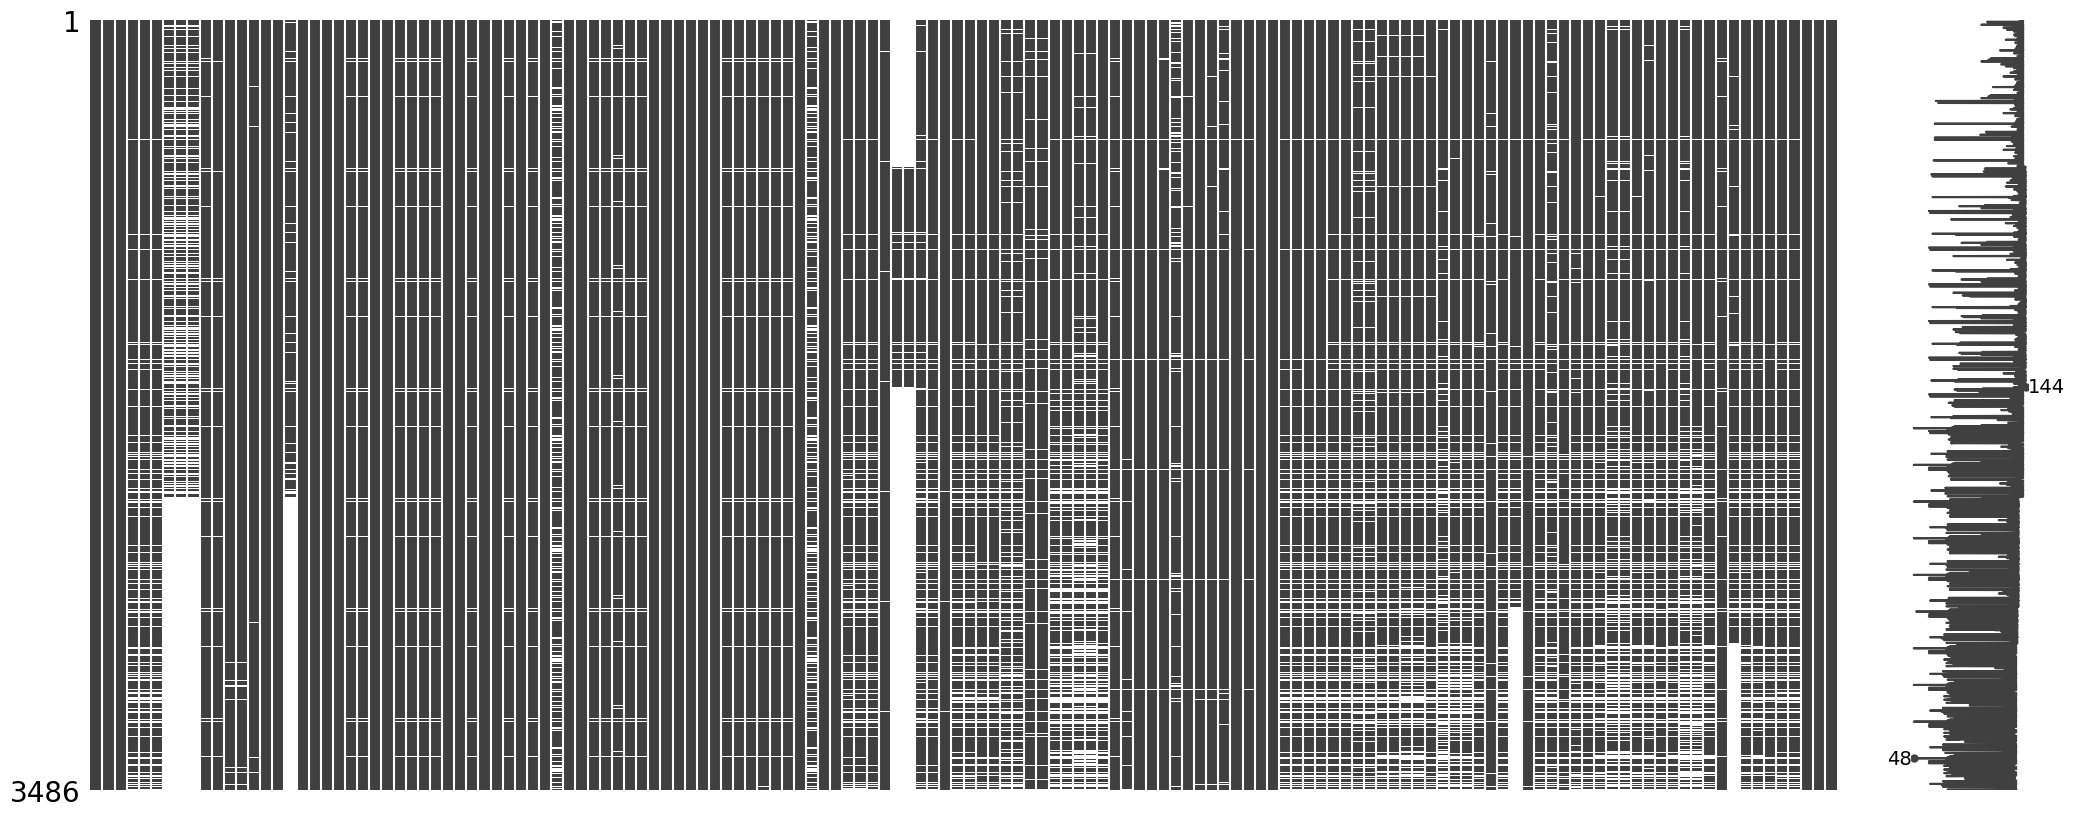

In [309]:
# Create a missingness matrix to get an overview of the patterns of missingness in the features and rows
msno.matrix(merged_gdf)

In [310]:
df_copy = merged_gdf.isna().sum()

df_copy = pd.DataFrame(df_copy, columns=['na_count'])

In [311]:
df_copy.sort_values(by='na_count', ascending=False).head(60)# Calculate the percentage of missing values for each column
missing_percent = merged_gdf.isnull().mean() * 100

# Create a DataFrame to display the results
missing_percent_df = pd.DataFrame({'Column': missing_percent.index, 'Missing (%)': missing_percent.values})

# Sort the DataFrame by the percentage of missing values in descending order
missing_percent_df = missing_percent_df.sort_values(by='Missing (%)', ascending=False)

# Display the DataFrame
missing_percent_df.head(35)

,Column,Missing (%)
67,pf_identity_inheritance_daughters,73.522662
66,pf_identity_inheritance_widows,73.522662
8,pf_rol_criminal,59.753299
6,pf_rol_procedural,59.753299
7,pf_rol_civil,59.753299
16,pf_ss_disappearances_organized,43.086632
117,ef_trade_movement_visit,28.829604
59,pf_expression_bti,28.427998
38,pf_assembly_freedom_bti,28.427998
135,ef_regulation_business_licensing,26.907631


## Selected outcome attributes

pf_expression
ef_score
pf_role_civil
hf_score

In [312]:
# Create a subset with all attributes except for the potential outcome-variables
df_attributes = merged_gdf.drop(columns=['ef_score','hf_score','pf_expression_bti', 'pf_rol_civil'])

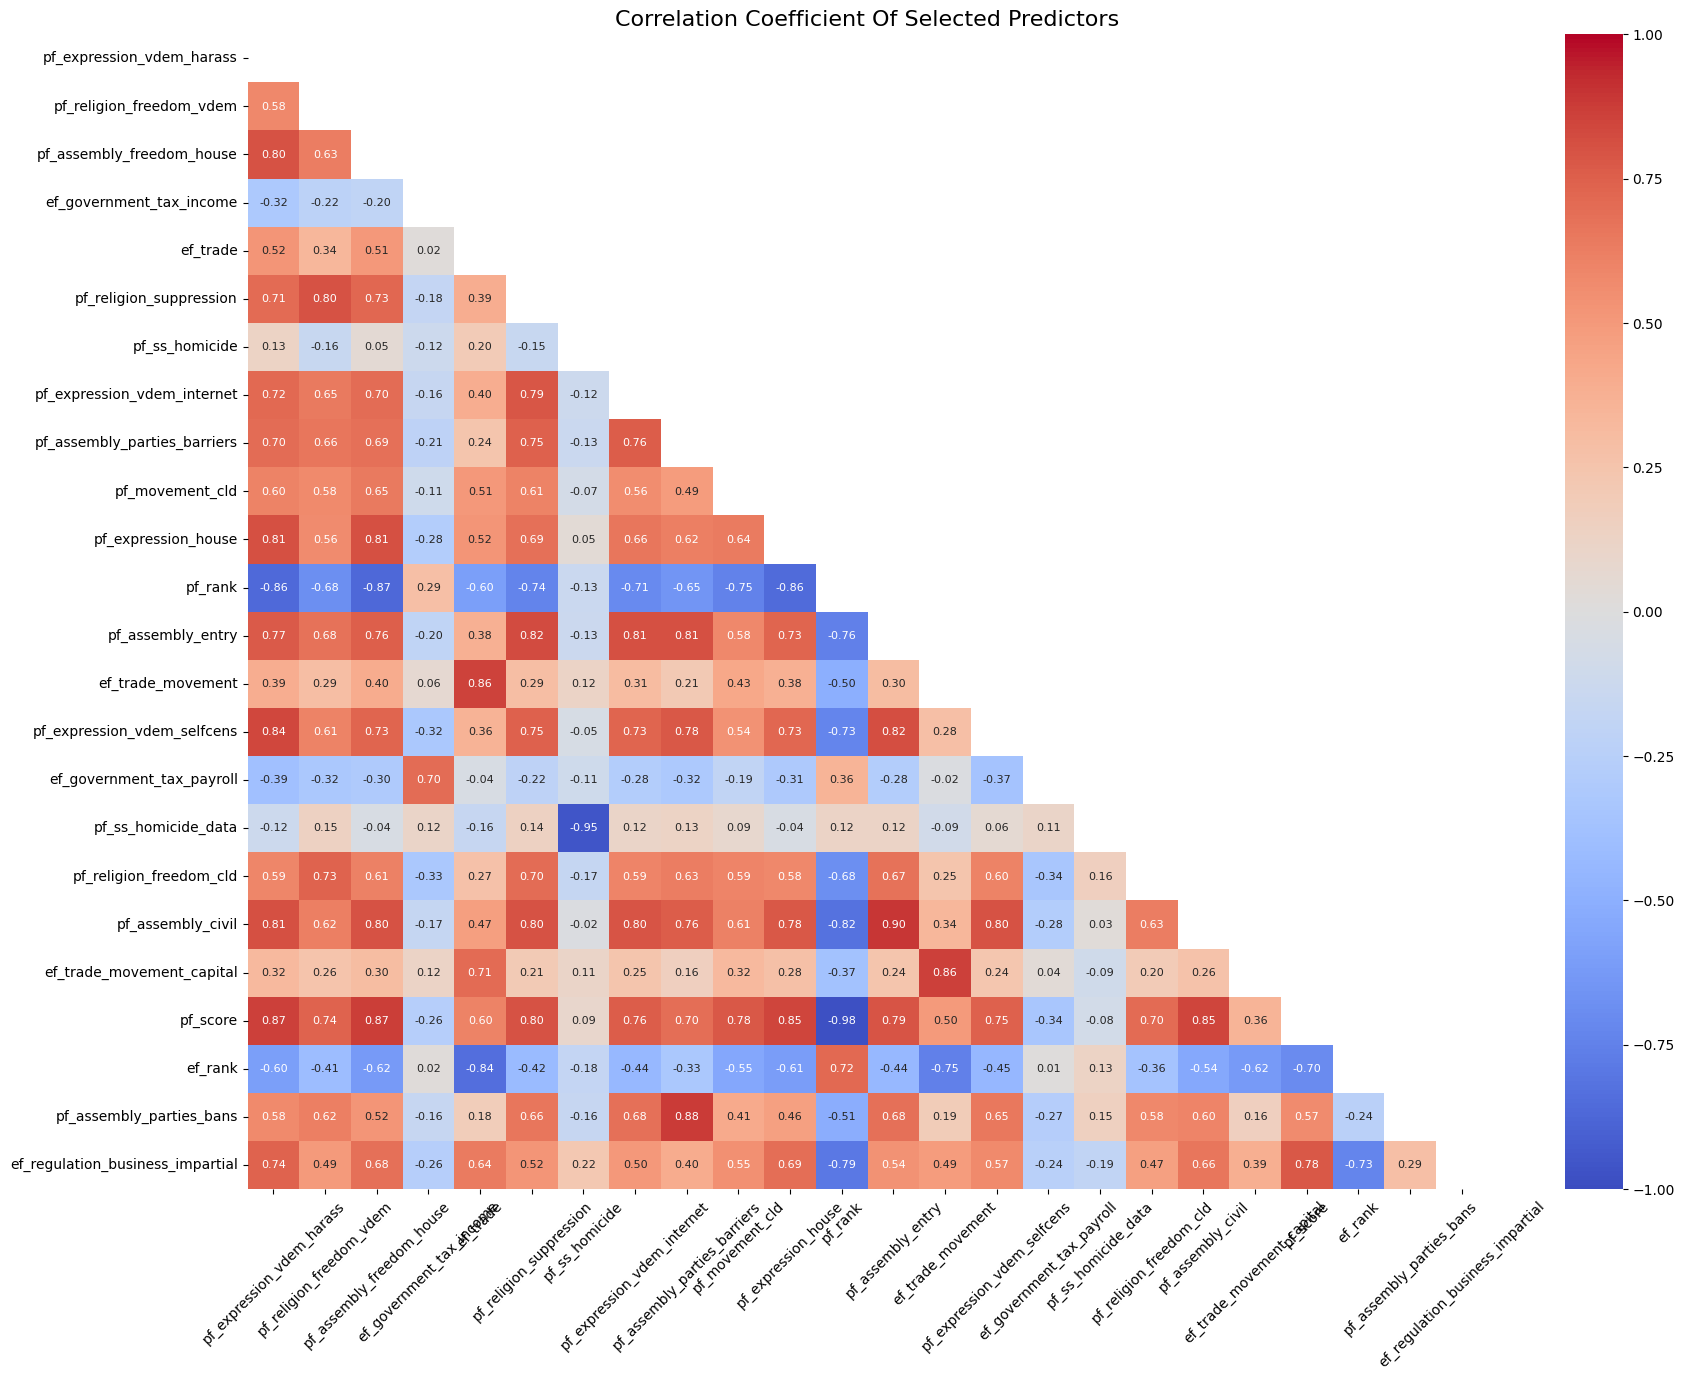

In [313]:
# Set correlation threshold
corr_threshold = 0.7

# A selected subset to visualize (as there are over 100's of attributes not all are showcased visually)
selected_columns = [
    'pf_expression_vdem_harass',
    'pf_religion_freedom_vdem',
    'pf_assembly_freedom_house',
    'ef_government_tax_income',
    'ef_trade',
    'pf_religion_suppression',
    'pf_ss_homicide',
    'pf_expression_vdem_internet',
    'pf_assembly_parties_barriers',
    'pf_movement_cld',
    'pf_expression_house',
    'pf_rank',
    'pf_assembly_entry',
    'ef_trade_movement',
    'pf_expression_vdem_selfcens',
    'ef_government_tax_payroll',
    'pf_ss_homicide_data',
    'pf_religion_freedom_cld',
    'pf_assembly_civil',
    'ef_trade_movement_capital',
    'pf_score',
    'ef_rank',
    'pf_assembly_parties_bans',
    'ef_regulation_business_impartial'
]

df_selected = df_attributes[selected_columns]

# Set figure size
plt.figure(figsize=(20, 15))

# Generate a mask to only show the upper triangle
mask = np.triu(np.ones_like(df_selected.corr(), dtype=bool))

# Generate heatmap
sns.heatmap(df_selected.corr(), annot=True, mask=mask, vmin=-1, vmax=1, cmap='coolwarm', fmt='.2f', annot_kws={"size": 8})

# Rotate x-axis tick labels
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

plt.title('Correlation Coefficient Of Selected Predictors', fontsize=16)
plt.show()

In [314]:
# Get correlation matrix
corr_matrix = df_attributes.corr()

# Extract features with high correlations
high_correlation_features = set()
for col in corr_matrix.columns:
    for row in corr_matrix.index:
        if col != row and abs(corr_matrix.loc[col, row]) > 0.85:
            high_correlation_features.add(col)
            high_correlation_features.add(row)

# Convert the set to a list
high_correlation_features = list(high_correlation_features)

# Print the list of features
print("Features with high correlations:")
for feature in high_correlation_features:
    print(feature)

Features with high correlations:
pf_identity_same_m
pf_ss_homicide_data
pf_assembly_parties_auton
ef_government_investment
pf_movement
pf_score
pf_movement_vdem_men
ef_government_transfers_data
pf_religion
pf_movement_vdem_foreign
pf_religion_suppression
pf_identity_inheritance_daughters
ef_trade_regulatory
ef_legal_judicial
pf_religion_freedom_cld
ef_trade_regulatory_compliance
pf_assembly_entry
ef_government_tax_payroll
pf_assembly_parties_bans
ef_government_tax_income
pf_movement_vdem_women
ef_government_tax
ef_trade_movement_capital
ef_trade_tariffs_mean
pf_expression_vdem_gov
ef_legal
hf_quartile
pf_assembly_freedom_bti
pf_rol_procedural
pf_ss_homicide
pf_assembly_parties
ef_government_consumption_data
pf_rank
pf_rol_criminal
pf_expression_cld
pf_ss_killings
pf_identity_inheritance
pf_assembly_freedom_house
pf_assembly_civil
ef_money_growth_data
pf_identity_inheritance_widows
ef_legal_courts
pf_movement_cld
pf_expression_vdem
ef_regulation_business_impartial
pf_identity
pf_movemen

In [315]:
# Create a VIF-function to remove high VIF-features sequentially

def find_high_vif_features(df, considered_features, vif_threshold=10):
    X = df[considered_features].copy()
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    X.dropna(inplace=True)

    # Add a constant for the VIF calculation
    X['intercept'] = 1

    # Calculate VIF values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    # Add features with infinite VIF values to high_vif_features list
    inf_vif_features = vif[vif['VIF'] == float('inf')]['Variable'].tolist()
    high_vif_features = inf_vif_features.copy()

    # Remove features with infinite VIF values from VIF DataFrame
    if inf_vif_features:
        print(f"Removing features with infinite VIF values: {', '.join(inf_vif_features)}")
        vif = vif[vif['VIF'] != float('inf')]
        considered_features = list(set(considered_features) - set(inf_vif_features))

    # Iteratively remove features with VIF values above the threshold
    while (vif['VIF'] > vif_threshold).any():
        max_vif_feature = vif.loc[vif['VIF'].idxmax()]['Variable']
        high_vif_features.append(max_vif_feature)
        print(f"Removing {max_vif_feature} with VIF = {vif.loc[vif['VIF'].idxmax()]['VIF']}")
        vif = vif[vif['Variable'] != max_vif_feature]
        considered_features.remove(max_vif_feature)

    return high_vif_features

# Set a VIF threshold
vif_threshold = 10

# Features to consider removing
considered_features = high_correlation_features

# Find features with high VIF
high_vif_features = find_high_vif_features(df_attributes, considered_features, vif_threshold)

Removing features with infinite VIF values: pf_identity_same_m, pf_assembly_parties_auton, pf_movement, pf_movement_vdem_men, pf_religion, pf_movement_vdem_foreign, pf_religion_suppression, pf_identity_inheritance_daughters, pf_religion_freedom_cld, pf_assembly_entry, ef_government_tax_payroll, pf_assembly_parties_bans, ef_government_tax_income, pf_movement_vdem_women, ef_government_tax, ef_trade_tariffs_mean, pf_expression_vdem_gov, pf_assembly_freedom_bti, pf_assembly_parties, pf_identity_inheritance, pf_assembly_freedom_house, pf_assembly_civil, pf_identity_inheritance_widows, pf_movement_cld, pf_expression_vdem, pf_movement_vdem, pf_assembly_parties_barriers, pf_expression_vdem_selfcens, pf_identity_same, pf_expression_vdem_cultural, pf_assembly_freedom_cld, pf_assembly_freedom, pf_assembly, pf_expression_vdem_internet, ef_trade_tariffs_mean_data, pf_identity_same_f, pf_religion_freedom, pf_religion_freedom_vdem, pf_expression_vdem_harass
Removing ef_government_consumption with VIF

In [316]:
# Remove columns with high VIF from df_attributes
df_attributes.drop(high_vif_features, axis=1, inplace=True)

### Impute the non-outcome variables with multiple interpolation

In [317]:
# Setup of the imputater and its controls
imp = IterativeImputer(max_iter=10, random_state=0)

# Exclude non-numerical columns
numerical_cols = df_attributes.select_dtypes(include=[np.number]).columns
df_numerical = df_attributes[numerical_cols]

# Perform multiple imputation
df_imputed = imp.fit_transform(df_numerical)

# Convert back to dataframe
df_imputed = pd.DataFrame(df_imputed, columns = df_numerical.columns)

# Replace the original numerical columns with the imputed ones
df_attributes[numerical_cols] = df_imputed

In [341]:
df_attributes.ef_regulation_labor_dismissal

0        6.299740912913362
1        7.755176153834103
2        6.632764230751155
3       2.5172538461136824
4        9.251725384611369
               ...        
3481                     0
3482                   NaN
3483                   NaN
3484                     0
3485                     0
Name: ef_regulation_labor_dismissal, Length: 3486, dtype: object

In [339]:
missing_data_cols = df_attributes.columns[df_attributes.isna().any()].tolist()
missing_data_cols

['ef_government_tax_income_data',
 'ef_government_tax_payroll_data',
 'ef_regulation_labor_dismissal']

In [330]:
df_attributes

,year,countries,region,pf_ss_disappearances_disap,pf_ss_disappearances_violent,pf_ss_disappearances_violent_data,pf_ss_disappearances_organized,pf_ss_disappearances_fatalities,pf_ss_disappearances_fatalities_data,pf_ss_disappearances_injuries,...,ef_regulation_business_burden,ef_regulation_business_start,ef_regulation_business_impartial,ef_regulation_business_licensing,ef_regulation_business_compliance,ef_regulation_business,ef_regulation,country_code,geometry,globalNorth
0,2020.0,Albania,Eastern Europe,10.0,10.000000,0.0,7.500000,10.000000,0.0,10.000000,...,6.000000,9.742477,5.9975,5.621940,7.175250,6.698118,7.112958,ALB,"POLYGON ((20.07142 42.56091, 20.10208 42.53347...",1.0
1,2020.0,Algeria,Middle East & North Africa,10.0,9.687083,25.0,5.000000,10.000000,0.0,10.000000,...,2.222222,9.305002,2.5775,8.771111,7.029528,5.686753,5.778953,DZA,"POLYGON ((8.62203 36.94137, 8.63222 36.88194, ...",0.0
2,2020.0,Angola,Sub-Saharan Africa,10.0,9.582498,25.0,7.500000,9.736578,5.0,9.971733,...,3.111111,8.730805,4.7025,7.916416,6.782923,5.696942,6.227545,AGO,"MULTIPOLYGON (((23.98621 -10.87046, 23.98805 -...",0.0
3,2020.0,Argentina,Latin America & the Caribbean,5.0,10.000000,0.0,7.500000,9.925379,2.0,10.000000,...,5.555556,9.579288,7.2675,5.726521,6.508295,6.225232,5.490538,ARG,"MULTIPOLYGON (((-68.64312 -54.88861, -68.63723...",0.0
4,2020.0,Armenia,Caucasus & Central Asia,10.0,10.000000,0.0,7.500000,10.000000,0.0,10.000000,...,5.111111,9.863530,6.2600,9.302574,7.040738,7.124727,7.756333,ARM,"POLYGON ((46.54038 38.87559, 46.51639 38.87804...",1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3481,2000.0,Venezuela,Latin America & the Caribbean,10.0,10.000000,0.0,8.065756,10.000000,0.0,10.000000,...,6.150000,6.268547,4.3100,4.693582,0.315142,4.692328,5.531397,VEN,"MULTIPOLYGON (((-61.18507 8.49674, -61.19417 8...",0.0
3482,2000.0,Vietnam,South Asia,10.0,10.000000,0.0,7.489113,10.000000,0.0,10.000000,...,2.571703,7.885638,3.7000,5.893919,0.000000,3.861879,4.416768,VNM,"MULTIPOLYGON (((104.08288 10.36486, 104.08663 ...",0.0
3483,2000.0,Yemen,Middle East & North Africa,5.0,10.000000,0.0,7.082752,8.170079,19.0,7.932996,...,6.222541,7.958966,1.1450,6.826241,7.115713,5.604763,6.686506,YEM,"MULTIPOLYGON (((52.23416 12.20111, 52.27888 12...",0.0
3484,2000.0,Zambia,Sub-Saharan Africa,10.0,10.000000,0.0,7.507364,10.000000,0.0,9.827262,...,12.524248,8.537578,7.0050,6.653403,8.520369,8.020982,6.799421,ZMB,"POLYGON ((32.94040 -9.40508, 32.93944 -9.41583...",0.0


### Remap the outcome-variables to a binary (0: non-missing, 1: missing)

<AxesSubplot:>

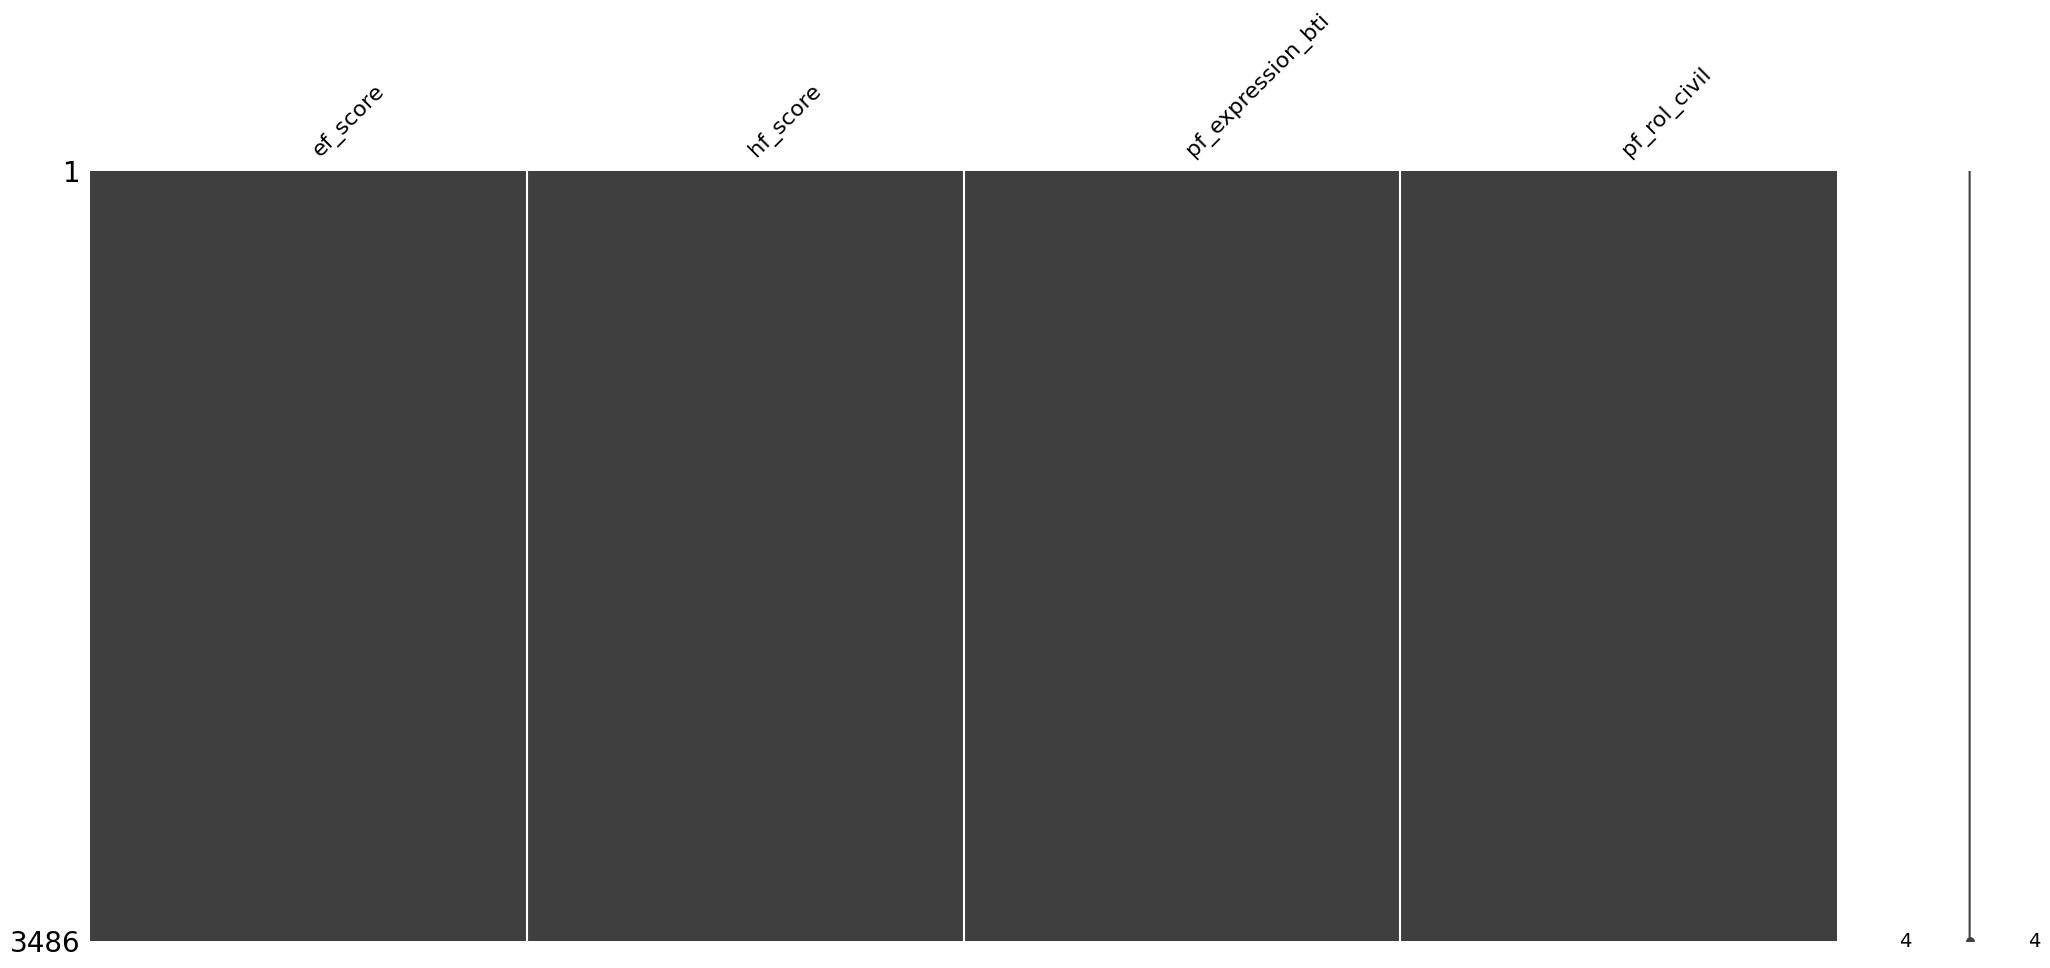

In [320]:
# Reappend the outcome-variables
df_outcome_variables = merged_gdf[['ef_score','hf_score','pf_expression_bti', 'pf_rol_civil']]

# Remap the outcome-variables to a binary 0-1 for classifying missingness
df_outcome_variables = df_outcome_variables.isna().astype(int)

# 0 for non-missing and 1 for missing
msno.matrix(df_outcome_variables)

# As seen below the attributes are now complete after the remapping

In [321]:
df_outcome_variables

,ef_score,hf_score,pf_expression_bti,pf_rol_civil
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,1
...,...,...,...,...
3481,0,0,0,1
3482,0,0,0,1
3483,1,1,0,1
3484,0,0,0,1


In [322]:
# Concatenate the DataFrames along the columns axis
df_result = pd.concat([df_attributes, df_outcome_variables], axis=1)

In [323]:
df_result.ef_score

0       0
1       0
2       0
3       0
4       0
       ..
3481    0
3482    0
3483    1
3484    0
3485    0
Name: ef_score, Length: 3486, dtype: int64

<AxesSubplot:>

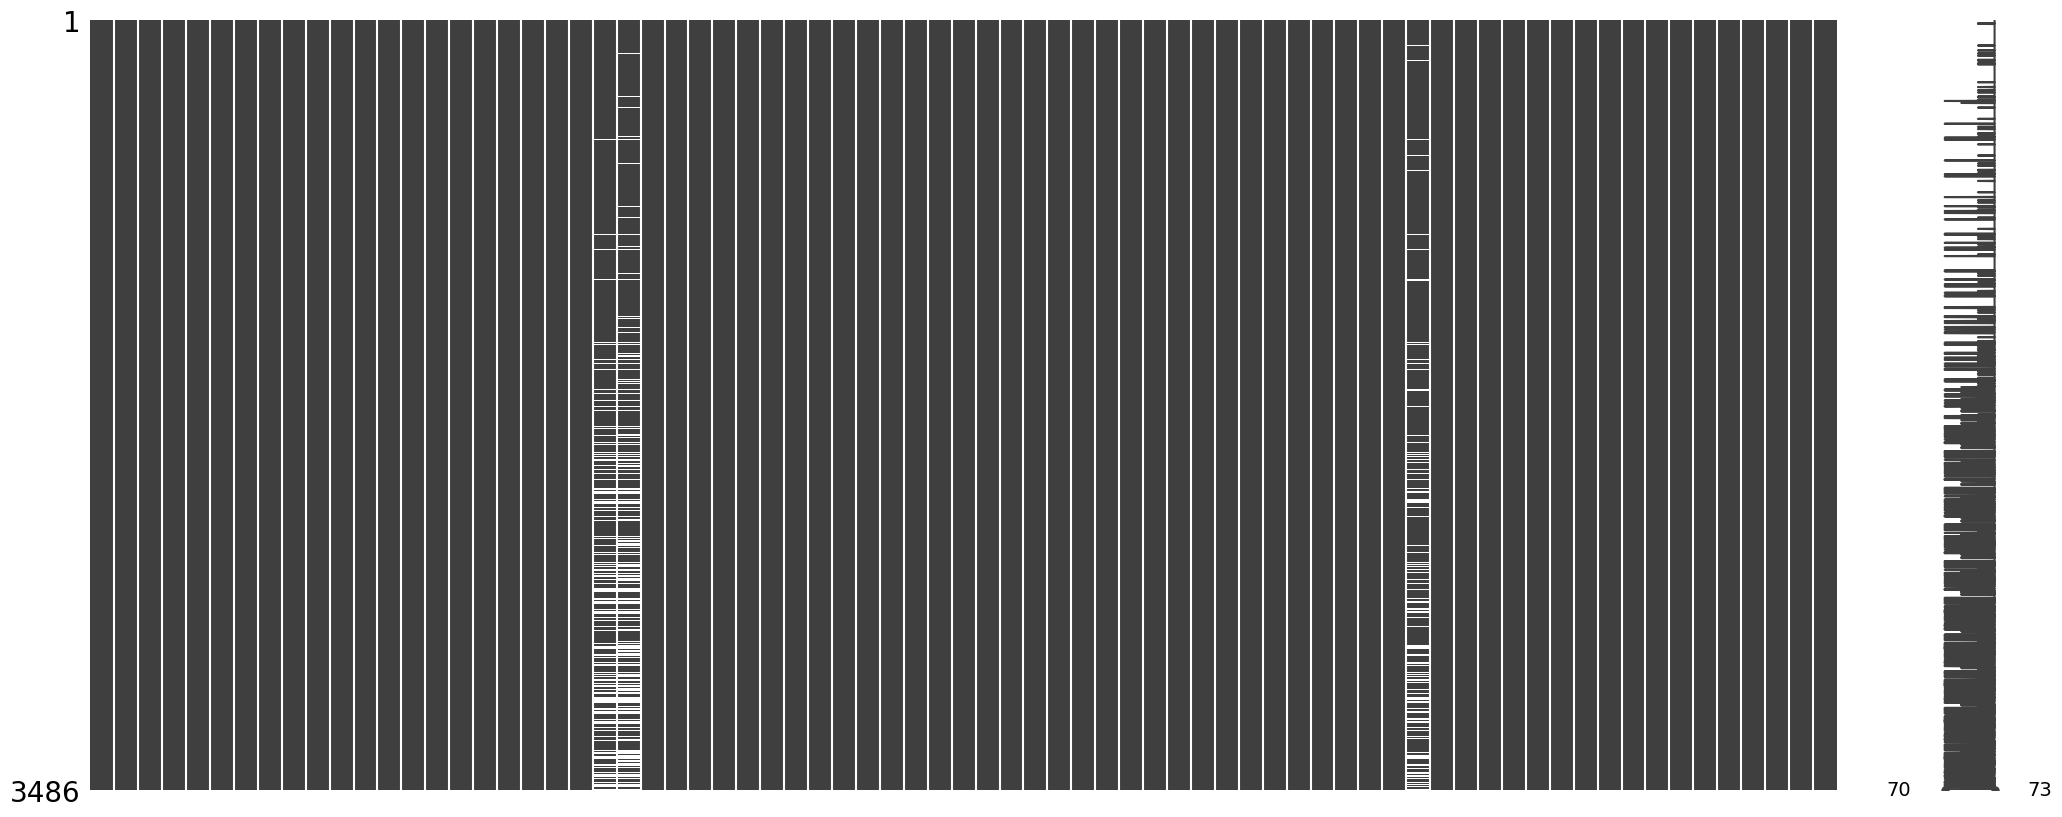

In [324]:
msno.matrix(df_result)

In [325]:
df_result.columns

Index(['year', 'countries', 'region', 'pf_ss_disappearances_disap',
       'pf_ss_disappearances_violent', 'pf_ss_disappearances_violent_data',
       'pf_ss_disappearances_organized', 'pf_ss_disappearances_fatalities',
       'pf_ss_disappearances_fatalities_data', 'pf_ss_disappearances_injuries',
       'pf_ss_disappearances_injuries_data', 'pf_ss_disappearances', 'pf_ss',
       'pf_expression_direct_killed', 'pf_expression_direct_killed_data',
       'pf_expression_direct_jailed', 'pf_expression_direct_jailed_data',
       'pf_expression_direct', 'pf_expression_cld', 'pf_identity_divorce',
       'pf_identity_fgm', 'ef_government_tax_income_data',
       'ef_government_tax_payroll_data', 'ef_government_soa', 'ef_government',
       'ef_legal_protection', 'ef_legal_military', 'ef_legal_integrity',
       'ef_legal_enforcement', 'ef_legal_regulatory', 'ef_legal_police',
       'ef_gender', 'ef_money_sd', 'ef_money_sd_data', 'ef_money_inflation',
       'ef_money_inflation_data', 'ef_

## Encoding categorical variables

In [326]:
# One-hot encode the 'countries' and 'region' columns
countries_dummies = pd.get_dummies(df_result['countries'], prefix='country')
region_dummies = pd.get_dummies(df_result['region'], prefix='region')

# Concatenate the one-hot encoded columns with the original DataFrame
df_encoded = pd.concat([df_result, countries_dummies, region_dummies], axis=1)

# Display the resulting DataFrame
df_encoded

,year,countries,region,pf_ss_disappearances_disap,pf_ss_disappearances_violent,pf_ss_disappearances_violent_data,pf_ss_disappearances_organized,pf_ss_disappearances_fatalities,pf_ss_disappearances_fatalities_data,pf_ss_disappearances_injuries,...,region_Caucasus & Central Asia,region_East Asia,region_Eastern Europe,region_Latin America & the Caribbean,region_Middle East & North Africa,region_North America,region_Oceania,region_South Asia,region_Sub-Saharan Africa,region_Western Europe
0,2020.0,Albania,Eastern Europe,10.0,10.000000,0.0,7.500000,10.000000,0.0,10.000000,...,0,0,1,0,0,0,0,0,0,0
1,2020.0,Algeria,Middle East & North Africa,10.0,9.687083,25.0,5.000000,10.000000,0.0,10.000000,...,0,0,0,0,1,0,0,0,0,0
2,2020.0,Angola,Sub-Saharan Africa,10.0,9.582498,25.0,7.500000,9.736578,5.0,9.971733,...,0,0,0,0,0,0,0,0,1,0
3,2020.0,Argentina,Latin America & the Caribbean,5.0,10.000000,0.0,7.500000,9.925379,2.0,10.000000,...,0,0,0,1,0,0,0,0,0,0
4,2020.0,Armenia,Caucasus & Central Asia,10.0,10.000000,0.0,7.500000,10.000000,0.0,10.000000,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3481,2000.0,Venezuela,Latin America & the Caribbean,10.0,10.000000,0.0,8.065756,10.000000,0.0,10.000000,...,0,0,0,1,0,0,0,0,0,0
3482,2000.0,Vietnam,South Asia,10.0,10.000000,0.0,7.489113,10.000000,0.0,10.000000,...,0,0,0,0,0,0,0,1,0,0
3483,2000.0,Yemen,Middle East & North Africa,5.0,10.000000,0.0,7.082752,8.170079,19.0,7.932996,...,0,0,0,0,1,0,0,0,0,0
3484,2000.0,Zambia,Sub-Saharan Africa,10.0,10.000000,0.0,7.507364,10.000000,0.0,9.827262,...,0,0,0,0,0,0,0,0,1,0


In [327]:
df_encoded.geometry

0       POLYGON ((20.07142 42.56091, 20.10208 42.53347...
1       POLYGON ((8.62203 36.94137, 8.63222 36.88194, ...
2       MULTIPOLYGON (((23.98621 -10.87046, 23.98805 -...
3       MULTIPOLYGON (((-68.64312 -54.88861, -68.63723...
4       POLYGON ((46.54038 38.87559, 46.51639 38.87804...
                              ...                        
3481    MULTIPOLYGON (((-61.18507 8.49674, -61.19417 8...
3482    MULTIPOLYGON (((104.08288 10.36486, 104.08663 ...
3483    MULTIPOLYGON (((52.23416 12.20111, 52.27888 12...
3484    POLYGON ((32.94040 -9.40508, 32.93944 -9.41583...
3485    POLYGON ((30.41576 -15.63187, 30.41729 -15.642...
Name: geometry, Length: 3486, dtype: geometry

In [328]:
# Save the DataFrame as a Parquet file
gdf = gpd.GeoDataFrame(df_encoded, geometry='geometry')

# Save the GeoDataFrame as a GeoParquet file
gdf.to_parquet('gdf_encoded.parquet', compression='snappy', index=False)

In [329]:
# Save the DataFrame as a Parquet file
gdf_no_ohe = gpd.GeoDataFrame(df_result, geometry='geometry')

# Save the GeoDataFrame as a GeoParquet file
gdf_no_ohe.to_parquet('gdf_no_ohe.parquet', compression='snappy', index=False)